In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import shutil
import numpy as np

In [4]:
import numpy as np
with open('test.npz','wb') as file:
    for i in range(10):
        d1 = np.random.random_sample(100)
        d2 = np.random.random_sample(100)
        np.savez_compressed(file,**{f'{i}_data_1': d1, f'{i}_data_2':d2})

np.load('test.npz').files

['9_data_1', '9_data_2']

In [1]:
from datasets import wikiset
wikiset.make_embeddings(wikiset.get(),'wiki_segments')
        

f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert
Embedding sentences:[..........][50/50] => DONE [0h 0min 14s][eta: 0h 0min 0s]   n 0s]    
Making sentence embeddings done in 19.89 s


In [2]:
## load embeddings
import numpy as np
from datasets import EmbeddedDataset
import segments
import matplotlib.pyplot as plt
with EmbeddedDataset('wiki_segments.npz') as ds:
    seg, emb = ds.get_file('data/7445232')
    print(np.min(ds.segment_lengths()))
    print(seg)
    print(segments.tags_to_array(seg))


3
[0 0 0 1 1 1 1 1 1 1 2 2]
[0 0 1 0 0 0 0 0 0 1 0 0]


Cliques: [[0, 11], [0, 3, 4, 1], [0, 3, 4, 9, 7], [2, 5], [5, 1], [6, 9, 7, 8], [6, 9, 7, 3], [8, 9, 4, 7], [10]]
initial segments: [[0, 1], [2], [3, 4], [5], [6, 7, 8, 9], [10], [11]]
merged similar segments: [[0, 1], [2], [3, 4], [5], [6, 7, 8, 9], [10], [11]]
[[0, 1, 2], [3, 4], [5], [6, 7, 8, 9], [10], [11]]
[[0, 1, 2, 3, 4], [5], [6, 7, 8, 9], [10], [11]]
[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9], [10], [11]]
[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9], [10, 11]]
[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]
merged small: [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]
Segment tags: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


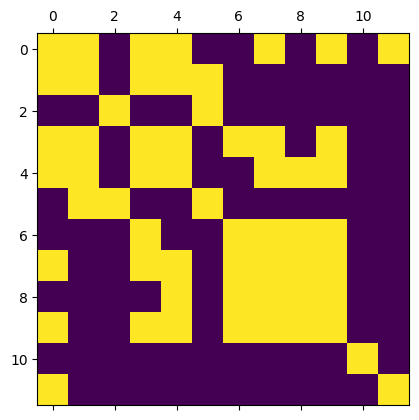

In [3]:
import matplotlib.pyplot as plt
mat = np.inner(emb,emb)
adj = np.array(mat > 0.3,dtype=int)
plt.matshow(adj)

from networkx.algorithms import clique
import networkx as nx
G = nx.Graph(adj)
segs = []
def sg(segs,i):
    for s in range(len(segs)):
        if i in segs[s]: return s
    else:
        return -1
def sgr(seg1,seg2,emb_mat):
    return np.mean([emb_mat[s1,s2] for s1 in seg1 for s2 in seg2])
def merged_seg(segs, i, j):
    s1 = segs.pop(max(i,j))
    s2 = segs.pop(min(i,j))
    segs.append(s2+s1)
    return sorted(segs)
def merge_small_seg(segs,emb_mat,min_n):
    for i in range(len(segs)):
        if len(segs[i]) < min_n:
            if i == (len(segs)-1):
                return merged_seg(segs,i-1,i)
            elif i == 0:
                return merged_seg(segs,i,i+1)
            elif sgr(segs[i],segs[i+1],emb_mat) > sgr(segs[i],segs[i-1],emb_mat):
                return merged_seg(segs,i,i+1)
            else:
                return merged_seg(segs,i-1,i)

print(f'Cliques: {list(clique.find_cliques(G))}')
cliques =  list(clique.find_cliques(G))
#segments from cliques
for q in cliques:
    for si,sj in ((i,j) for i in q for j in q):
        if sj - si != 1: continue
        if sg(segs,si) < 0 and sg(segs,sj) < 0:
            segs.append([si,sj])
        elif sg(segs,si) >= 0 and sg(segs,sj) < 0:
            segs[sg(segs,si)].append(sj)
        elif sg(segs,si) < 0 and sg(segs,sj) >= 0:
            segs[sg(segs,sj)].append(si)
# fill orphaned sentences
for i in range(len(emb)):
    if sg(segs,i) < 0:
        segs.append([i])

segs = sorted(segs)
print(f'initial segments: {segs}')
for q in cliques:
    for si,sj in ((i,j) for i in q for j in q):
        if sg(segs,si) - sg(segs,sj) == 1:
            segs = merged_seg(segs,sg(segs,si),sg(segs,sj))
    
print(f'merged similar segments: {segs}')
N_MIN_SEG = 3

num_small_segs = lambda s: sum([1 if len(es) < N_MIN_SEG else 0 for es in s])
while num_small_segs(segs) > 0:
    segs = merge_small_seg(segs,mat,N_MIN_SEG)
    print(segs)

print(f'merged small: {segs}')

#to tags:
seg_tags = []
for i in range(len(segs)):
    seg_tags += [i]*len(segs[i])
print(f"Segment tags: {seg_tags}")



In [7]:
def sbert_graphseg(emb,threshold = 0.5,n_min_seg = 3):
    mat = np.inner(emb,emb)
    adj = np.array(mat > threshold,dtype=int)
    G = nx.Graph(adj)
    cliques =  list(clique.find_cliques(G))
    segs = []

    #segments from cliques
    for q in cliques:
        for si,sj in ((i,j) for i in q for j in q):
            if sj - si != 1: continue
            if sg(segs,si) < 0 and sg(segs,sj) < 0:
                segs.append([si,sj])
            elif sg(segs,si) >= 0 and sg(segs,sj) < 0:
                segs[sg(segs,si)].append(sj)
            elif sg(segs,si) < 0 and sg(segs,sj) >= 0:
                segs[sg(segs,sj)].append(si)

    # fill orphaned sentences
    for i in range(len(emb)):
        if sg(segs,i) < 0:
            segs.append([i])
    segs = sorted(segs)

    # Merge similar segments
    for q in cliques:
        for si,sj in ((i,j) for i in q for j in q):
            if sg(segs,si) - sg(segs,sj) == 1:
                segs = merged_seg(segs,sg(segs,si),sg(segs,sj))

    #Merge small segments
    num_small_segs = lambda s: sum([1 if len(es) < n_min_seg else 0 for es in s])
    while num_small_segs(segs) > 0:
        segs = merge_small_seg(segs,mat,N_MIN_SEG)

    #to tags:
    seg_tags = []
    for i in range(len(segs)):
        seg_tags += [i]*len(segs[i])
    return segments.tags_to_array(seg_tags)
sbert_graphseg(emb,0.5,3)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


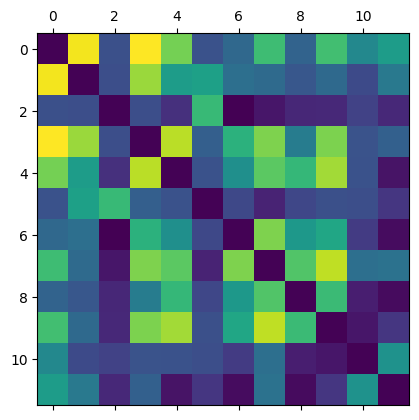

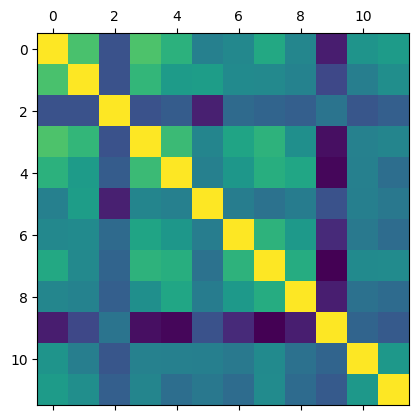

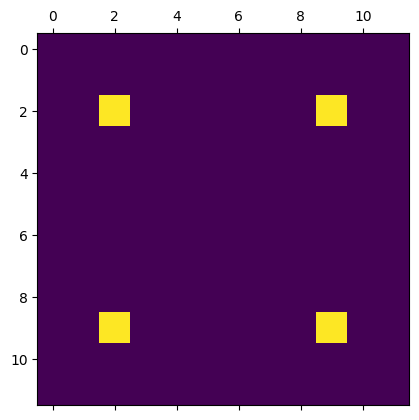

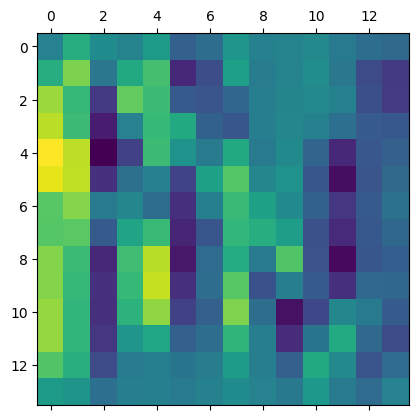

In [11]:
import segments
from scipy import signal

mat = np.inner(emb,emb)
segs = segments.tags_to_array(seg)
import matplotlib.pyplot as plt
plt.matshow(mat - np.identity(mat.shape[0]))
eemb = emb * (((segs+1)*-2)+3)[:,np.newaxis]
ezemb = np.ones_like(emb) * segs[:,np.newaxis]
plt.matshow(np.inner(eemb,eemb))
plt.matshow(np.inner(ezemb,ezemb))

print(ezemb)
sob = signal.convolve2d(mat-np.identity(mat.shape[0]),[[1,0,-1],[2,0,-2],[1,0,-1]])
plt.matshow(sob)

0.29812944
0.20978339


array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True, False, False])

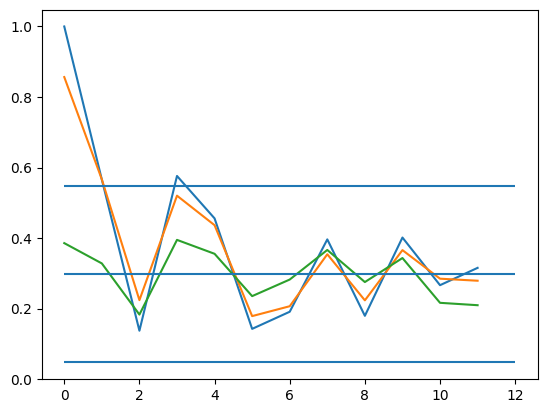

In [48]:
plt.plot(mat[0])
plt.plot(np.convolve(mat[0],[0.1,0.8,0.1],'same'))
print(np.mean(mat))
#plt.plot(mat[145])
print(np.mean(mat[-1]))
plt.plot(np.mean(mat,0))
mean_cross = np.mean(np.mean(mat,0))
std_cross = np.mean(np.std(mat,0))
plt.hlines([mean_cross, mean_cross + std_cross, mean_cross-std_cross],0,len(emb))

tau = np.mean(np.mean(mat,0))-np.std(np.mean(mat,0))/2
np.mean(mat,0) > tau

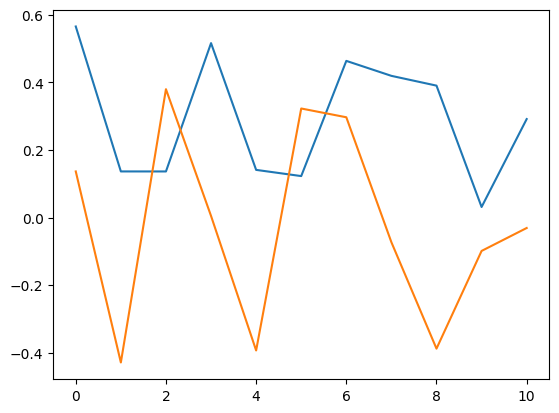

In [7]:
import algorithms
ss = algorithms.sim_score(emb)
plt.plot(ss)
se = np.convolve(ss,[1,0,-1],'same')
plt.plot(se)

[0.5658605, 0.13646336, 0.1363967, 0.51654565, 0.14105415, 0.12268574, 0.46394163, 0.41959375, 0.39063486, 0.031103242, 0.29159153]


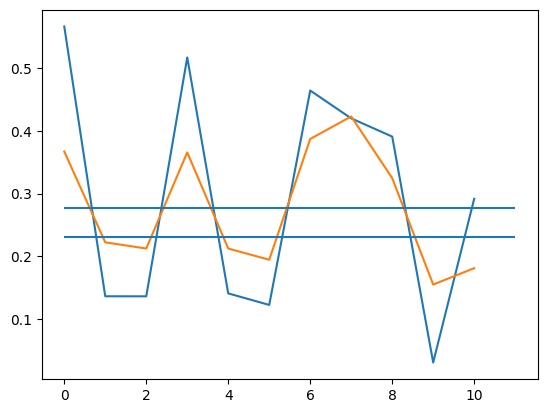

Local minima: [2 5 9]
[0.40473972 0.40480638 0.02465743 0.37384689 0.3922153  0.05095941
 0.07313338 0.08761284 0.39762278]
Embeddings: (12, 512) local_minima: (3,) depth score: (9,) : mean = 0.24551045770446459 : std = 0.16770726609141962 : m-s/2 = 0.16165682465875478
Divisions: (2,)


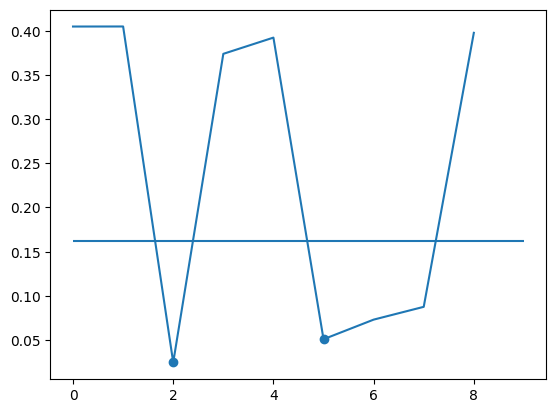

In [9]:
from evaluation import evaluate_segmenter
from algorithms import simple_seg
from datasets import EmbeddedDataset

with EmbeddedDataset('wiki_segments.npz') as ds:
    evaluate_segmenter(ds,sbert_graphseg,4)
    evaluate_segmenter(ds,simple_seg,4)

Pmean: 0.4854334393499689 Pstv: 0.18710556410589466
Wmean: 0.5174519719608535 Wstv: 0.18092045815427316
 argmin: [3]
Pmean: 0.5136592774410698 Pstv: 0.17960686346164936
Wmean: 0.6584883230674393 Wstv: 0.13494428650235046
